Problem 1
=====

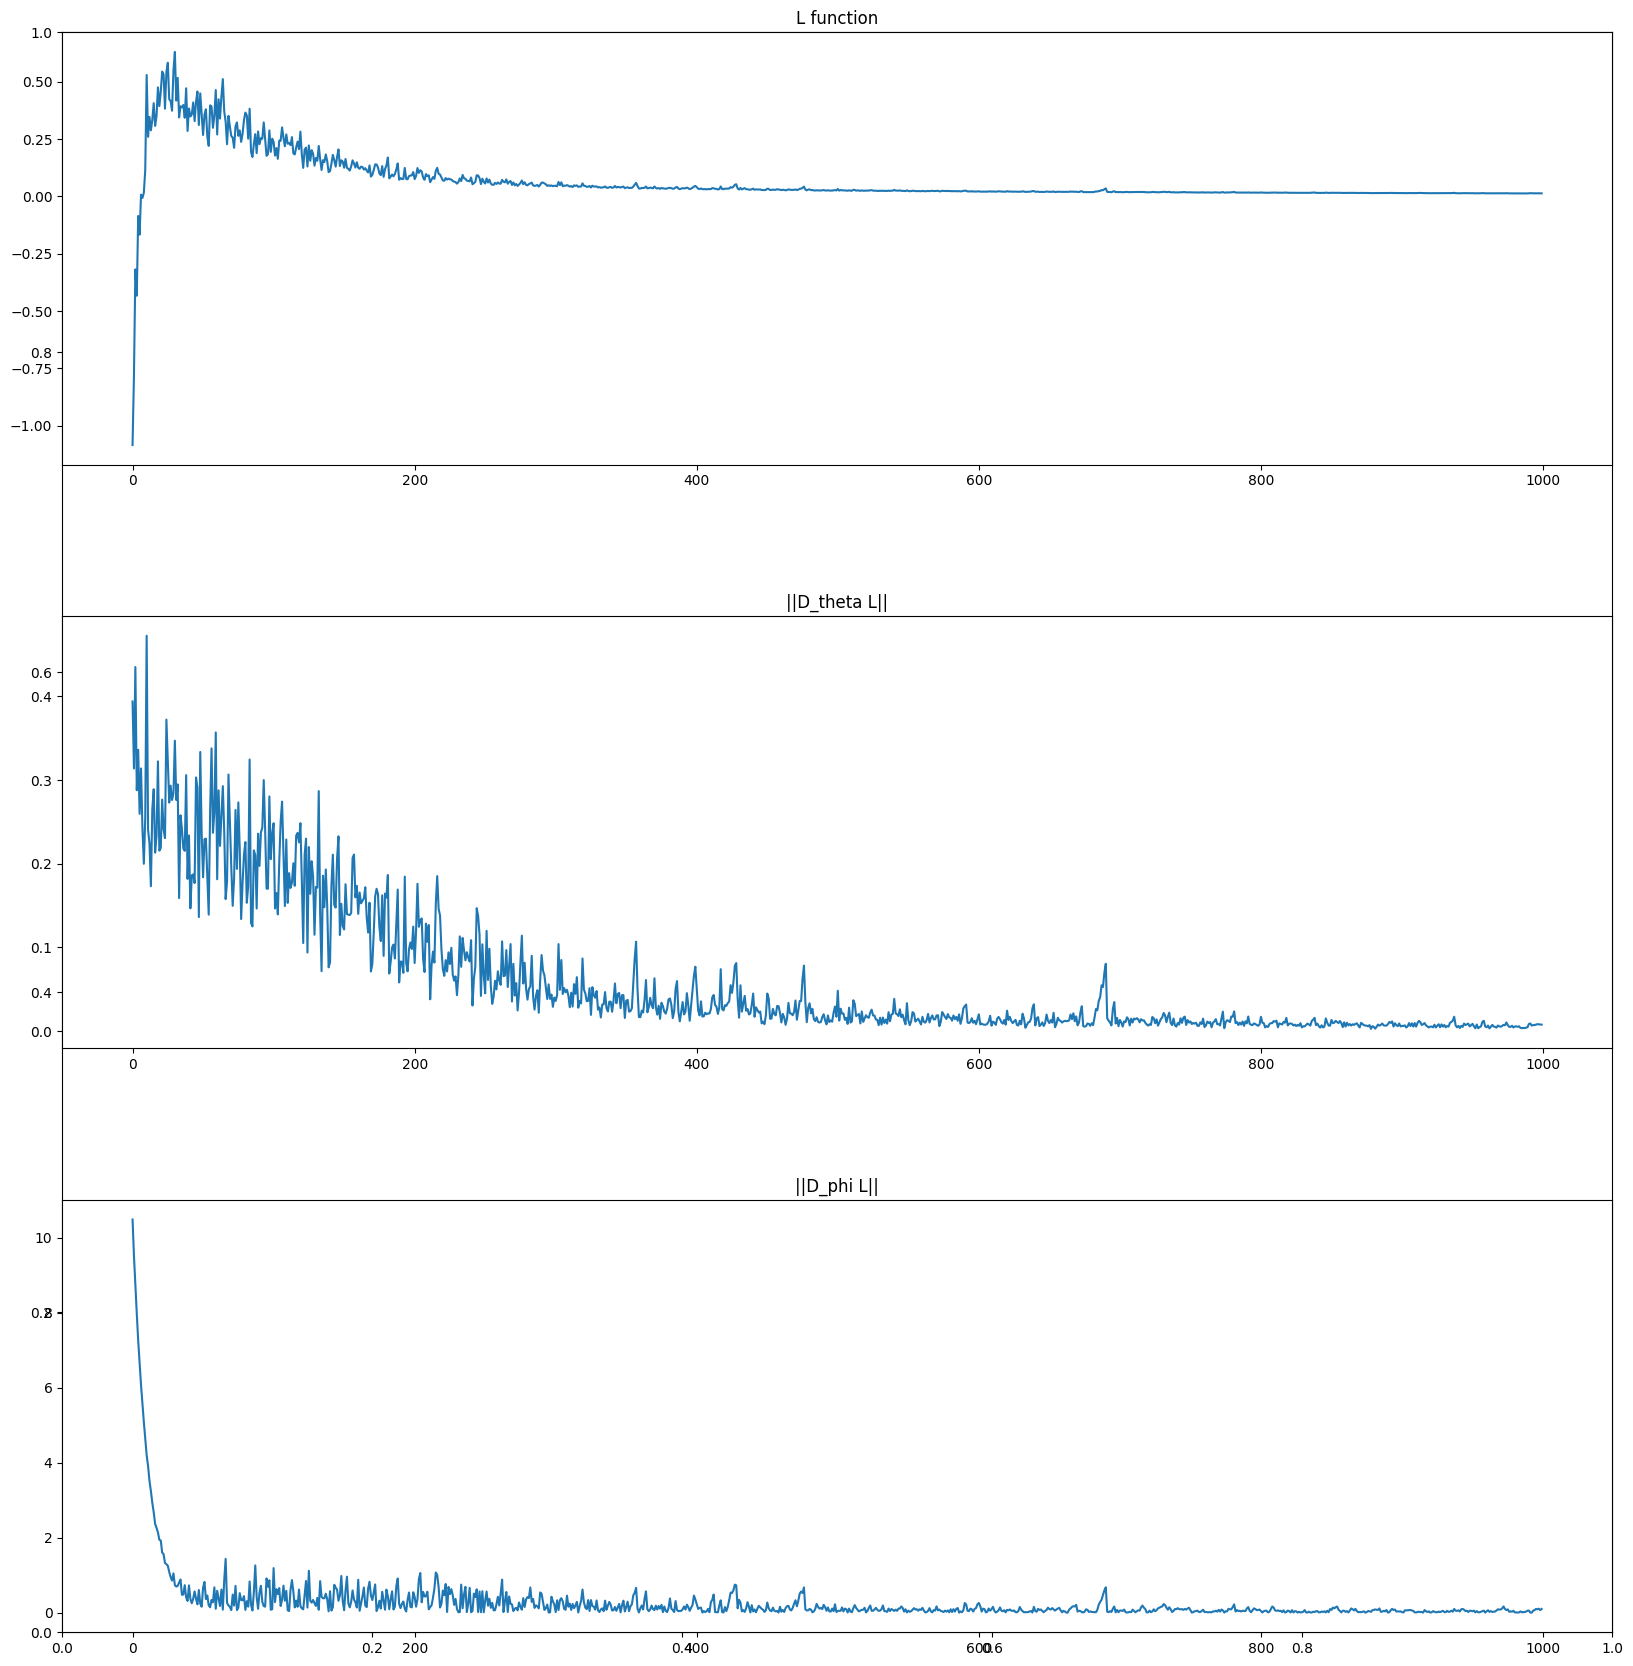

In [7]:
import numpy as np
from matplotlib import pyplot as plt

N, p = 30, 20
np.random.seed(0)
X = np.random.randn(N,p)
Y = 2*np.random.randint(2, size = N) - 1
lamda = 30

theta = 0.1 * np.random.randn(p)
phi = 0.1 * np.random.randn(p)
alpha = 3e-1
beta = 1e-4

epoch = 1000
L_val = []
d_phi_val = []
d_theta_val = []

for _ in range(epoch):
    for __ in range(N):
        idx = np.random.randint(N)
        x_i = X[idx]
        y_i = Y[idx]

        # Compute the gradients for the selected sample
        d_phi_i = (y_i / (1 + np.exp(y_i * ((x_i - phi) @ theta)))) * theta - lamda * phi
        d_theta_i = (-y_i / (1 + np.exp(y_i * ((x_i - phi) @ theta)))) * (x_i - phi)

        # Update phi and theta
        phi += beta * d_phi_i
        theta -= alpha * d_theta_i

    L_i = np.average(np.log(1 + np.exp(-Y * ((X - phi.reshape(1,-1)) @ theta)))) - lamda/2 * np.linalg.norm(phi, axis=0, ord=2) **2
    d_phi = np.average(Y / (1 + np.exp(Y * ((X-phi.reshape(1,-1)) @ theta)))) * theta - lamda * phi
    d_theta = np.average(( -Y / (1 + np.exp(Y * ((X-phi.reshape(1,-1)) @ theta))) ).reshape(-1,1)*(X-phi.reshape(1,-1)), axis=0)
    
    L_val.append(L_i)
    d_phi_val.append(d_phi)
    d_theta_val.append(d_theta)

fig, ax = plt.subplots(figsize=(20, 20))
plt.subplots_adjust(left=0.125,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.2,
                    hspace=0.35)
plt.subplot(3, 1, 1)
plt.title("L function")
plt.plot(L_val)
plt.subplot(3, 1, 2)
plt.title("||D_theta L||")
plt.plot(np.linalg.norm(d_theta_val, axis=1, ord=2))
plt.subplot(3, 1, 3)
plt.title("||D_phi L||")
plt.plot(np.linalg.norm(d_phi_val, axis=1, ord=2))
plt.show()


Problem 3
=====

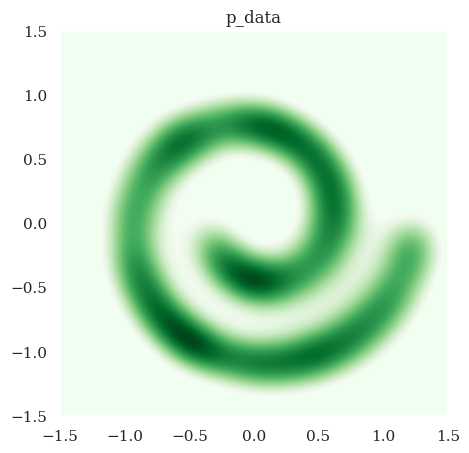

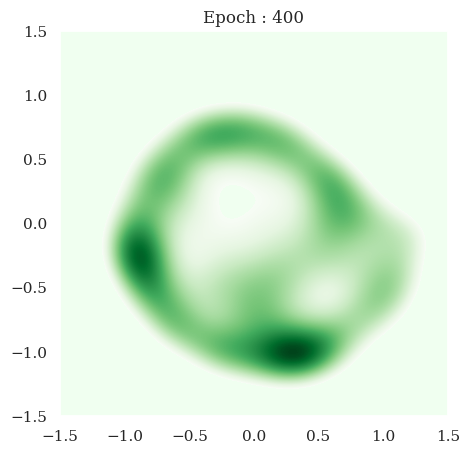

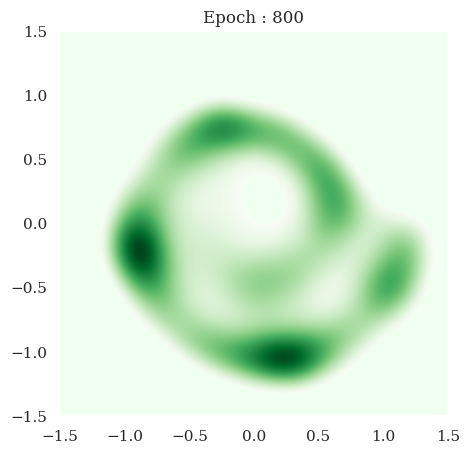

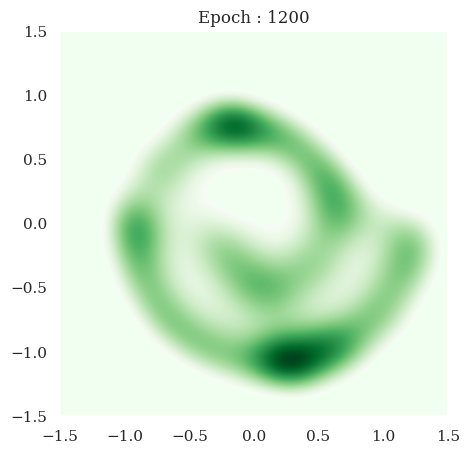

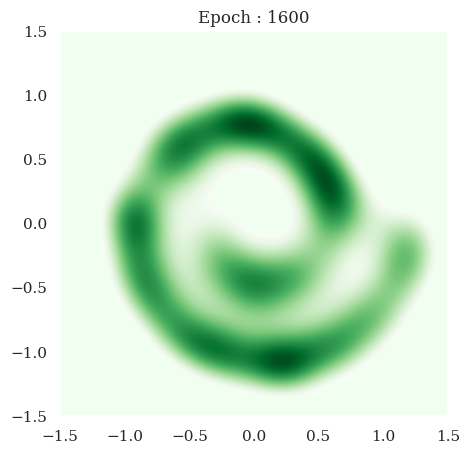

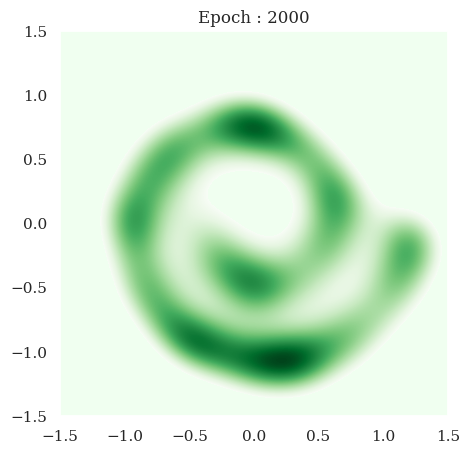

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, TensorDataset, DataLoader
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

"""
Step 0 : Define training configurations
"""

batch_size = 64
learning_rate = 5e-4
num_epochs = 2000
reg_coeff = 500
# device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = "mps"


"""
Step 1 : Define custom dataset 
"""

def make_swiss_roll(n_samples=2000, noise = 1.0, dimension = 2, a = 20, b = 5):
    """
    Generate 2D swiss roll dataset 
    """
    t = 2 * np.pi * np.sqrt(np.random.uniform(0.25,4,n_samples))
    
    X = 0.1 * t * np.cos(t)
    Y = 0.1 * t * np.sin(t)
    
    errors = 0.025 * np.random.multivariate_normal(np.zeros(2), np.eye(dimension), size = n_samples)
    X += errors[:, 0]
    Y += errors[:, 1]
    return np.stack((X, Y)).T

def show_data(data, title):
    """
    Plot the data distribution
    """
    sns.set(rc={'axes.facecolor': 'honeydew', 'figure.figsize': (5.0, 5.0)})
    plt.figure(figsize = (5, 5))
    plt.rc('text', usetex = False)
    plt.rc('font', family = 'serif')
    plt.rc('font', size = 10)
    
    g = sns.kdeplot(x=data[:, 0], y=data[:, 1], fill=True, thresh=0.1, levels=1000, cmap="Greens")
    
    g.grid(False)
    plt.margins(0, 0)
    plt.xlim(-1.5,1.5)
    plt.ylim(-1.5,1.5)
    plt.title(title)
    plt.show()


"""
Step 2 : Define custom dataset and dataloader. 
"""

class SwissRollDataset(Dataset) : 
    def __init__(self, data) : 
        super().__init__()
        self.data = torch.from_numpy(data)
    
    def __len__(self) : 
        return len(self.data)
    
    def __getitem__(self, idx) :
        return self.data[idx]

    
data = make_swiss_roll()
dataset = SwissRollDataset(data)
loader = DataLoader(dataset, batch_size = batch_size, shuffle = True)

sns.set(rc={'axes.facecolor': 'honeydew', 'figure.figsize': (5.0, 5.0)})
plt.figure(figsize = (5, 5))
plt.rc('text', usetex = False)
plt.rc('font', family = 'serif')
plt.rc('font', size = 10)

g = sns.kdeplot(x=data[:, 0], y=data[:, 1], fill=True, thresh=0.1, levels=1000, cmap="Greens")

g.grid(False)
plt.margins(0, 0)
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.title('p_data')
plt.savefig('swiss_roll_true.png')
plt.show()

"""
Step 3 : Implement models
"""

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(2, 128) 
        self.fc2 = nn.Linear(128, 128)
        self.fc3_mean = nn.Linear(128, 2) 
        self.fc3_logstd = nn.Linear(128, 2)

    def forward(self, x):
        h1 = nn.functional.leaky_relu(self.fc1(x), negative_slope=0.2)
        h2 = torch.tanh(self.fc2(h1))
        return self.fc3_mean(h2), self.fc3_logstd(h2)

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(2, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 2) 

    def forward(self, z):
        h1 = nn.functional.leaky_relu(self.fc1(z), negative_slope=0.2)
        h2 = torch.tanh(self.fc2(h1))
        return self.fc3(h2)

encoder = Encoder().to(device)
decoder = Decoder().to(device)

optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()),lr = 5e-4)

def log_p(x_hat, x):
    mse = nn.MSELoss().to(device)
    return -mse(x_hat, x)

# reparametrization trick
def reparametrization_trick(mu, log_std):
    z = torch.randn_like(mu)*log_std.exp()+mu
    return z

def kl_div(mu, log_std):
    kl = -log_std - 0.5 + (torch.exp(2 * log_std) + mu ** 2) * 0.5
    kl = kl.sum(1).mean()
    return kl

"""
Step 4 : Train models
""" 
for epoch in range(1,num_epochs+1) : 
    for batch_idx, x in enumerate(loader) : 
        x = x.float().to(device)
        
        mu, log_std = encoder(x)
        z = reparametrization_trick(mu, log_std)
        recon_x = decoder(z)
        
        recon_loss = -log_p(recon_x,x)
        regularizer = kl_div(mu,log_std)
        
        loss = recon_loss*reg_coeff + regularizer
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        print(f"[Epoch {epoch:3d}] Processing batch #{batch_idx:3d} reconstruction loss: {recon_loss.item():.6f} regularization loss {regularizer.item():.6f} train_loss: {loss.item():.6f}", end='\r')
    
    # Visualize the intermediate result
    if epoch % (num_epochs // 5) == 0:
        z = torch.randn(2000,2).to(device)  # 2000 samples to match the make_swiss_roll function
        data = decoder(z).detach().cpu().numpy()
        
        sns.set(rc={'axes.facecolor': 'honeydew', 'figure.figsize': (5.0, 5.0)})
        plt.figure(figsize = (5, 5))
        plt.rc('text', usetex = False)
        plt.rc('font', family = 'serif')
        plt.rc('font', size = 10)

        g = sns.kdeplot(x=data[:, 0], y=data[:, 1], fill=True, thresh=0.1, levels=1000, cmap="Greens")

        g.grid(False)
        plt.margins(0, 0)
        plt.xlim(-1.5,1.5)
        plt.ylim(-1.5,1.5)
        plt.title(f"Epoch : {epoch}")
        plt.show()
        


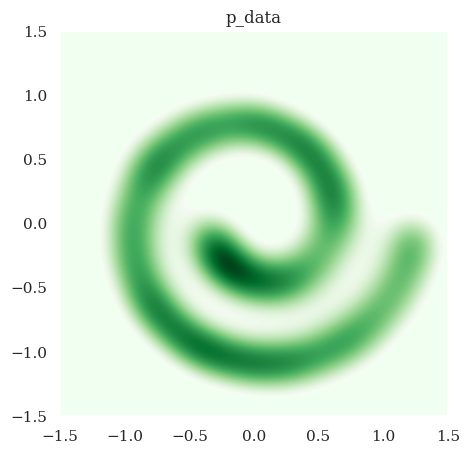

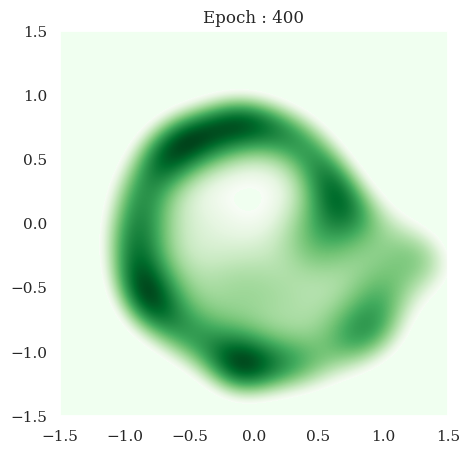

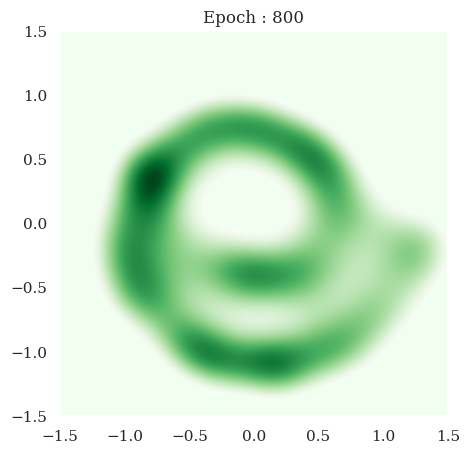

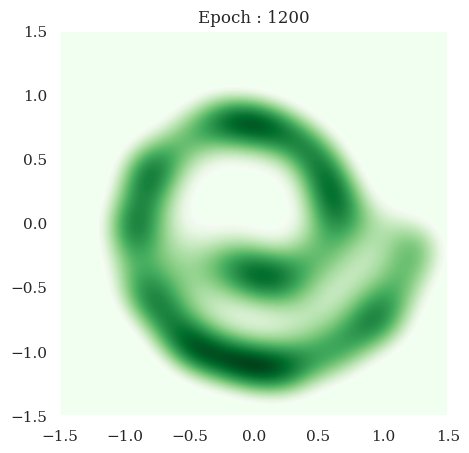

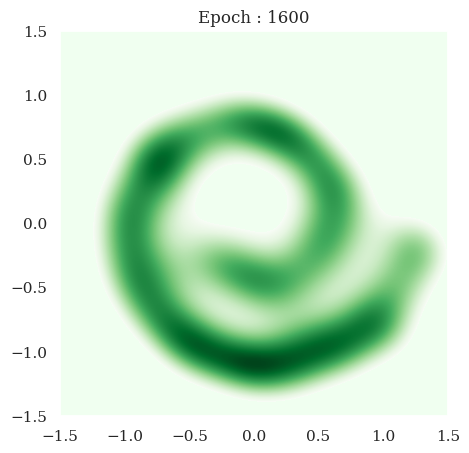

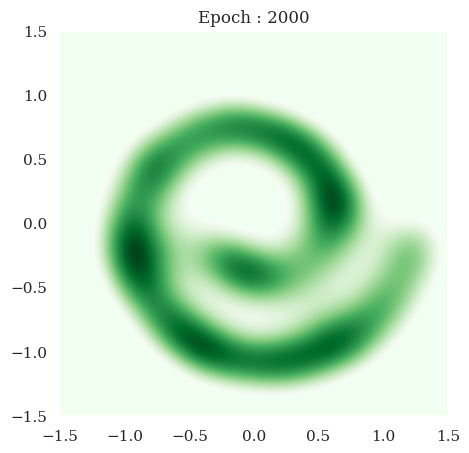

In [14]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, TensorDataset, DataLoader
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

"""
Step 0 : Define training configurations
"""

batch_size = 64
learning_rate = 5e-4
num_epochs = 2000
# device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = "mps"

"""
Step 1 : Define custom dataset 
"""

def make_swiss_roll(n_samples=2000, noise = 1.0, dimension = 2, a = 20, b = 5):
    """
    Generate 2D swiss roll dataset 
    """
    t = 2 * np.pi * np.sqrt(np.random.uniform(0.25,4,n_samples))
    
    X = 0.1 * t * np.cos(t)
    Y = 0.1 * t * np.sin(t)
    
    errors = 0.025 * np.random.multivariate_normal(np.zeros(2), np.eye(dimension), size = n_samples)
    X += errors[:, 0]
    Y += errors[:, 1]
    return np.stack((X, Y)).T

def show_data(data, title):
    """
    Plot the data distribution
    """
    sns.set(rc={'axes.facecolor': 'honeydew', 'figure.figsize': (5.0, 5.0)})
    plt.figure(figsize = (5, 5))
    plt.rc('text', usetex = False)
    plt.rc('font', family = 'serif')
    plt.rc('font', size = 10)
    
    g = sns.kdeplot(x=data[:, 0], y=data[:, 1], fill=True, thresh=0.1, levels=1000, cmap="Greens")
    
    g.grid(False)
    plt.margins(0, 0)
    plt.xlim(-1.5,1.5)
    plt.ylim(-1.5,1.5)
    plt.title(title)
    plt.show()


"""
Step 2 : Define custom dataset and dataloader. 
"""

class SwissRollDataset(Dataset) : 
    def __init__(self, data) : 
        super().__init__()
        self.data = torch.from_numpy(data)
    
    def __len__(self) : 
        return len(self.data)
    
    def __getitem__(self, idx) :
        return self.data[idx]

    
data = make_swiss_roll()
dataset = SwissRollDataset(data)
loader = DataLoader(dataset, batch_size = batch_size, shuffle = True)

sns.set(rc={'axes.facecolor': 'honeydew', 'figure.figsize': (5.0, 5.0)})
plt.figure(figsize = (5, 5))
plt.rc('text', usetex = False)
plt.rc('font', family = 'serif')
plt.rc('font', size = 10)

g = sns.kdeplot(x=data[:, 0], y=data[:, 1], fill=True, thresh=0.1, levels=1000, cmap="Greens")

g.grid(False)
plt.margins(0, 0)
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.title('p_data')
plt.savefig('swiss_roll_true.png')
plt.show()

"""
Step 3 : Implement models
"""

class Generator(nn.Module):
    def __init__(self, g_input_dim, g_output_dim):
        super(Generator, self).__init__()       
        self.fc1 = nn.Linear(g_input_dim, 32)
        self.fc2 = nn.Linear(self.fc1.out_features, g_output_dim)

    # forward method
    def forward(self, x): 
        x = nn.functional.tanh(self.fc1(x))
        return self.fc2(x)
    
class Discriminator(nn.Module):
    def __init__(self, d_input_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(d_input_dim, 128)
        self.fc2 = nn.Linear(128,128)
        self.fc3 = nn.Linear(128,1)
    
    # forward method
    def forward(self, x):
        x = nn.functional.tanh(self.fc1(x))
        x = nn.functional.dropout(x,0.3)
        x = nn.functional.tanh(self.fc2(x))
        x = nn.functional.dropout(x,0.3)
        return torch.sigmoid(self.fc3(x))

z_dim = 100

G = Generator(g_input_dim = z_dim, g_output_dim = 2).to(device)
D = Discriminator(d_input_dim = 2).to(device)

G_optimizer = torch.optim.Adam(G.parameters(), lr = 5e-4)
D_optimizer = torch.optim.Adam(D.parameters(), lr = 5e-4)

"""
Step 4 : Train models
""" 
for epoch in range(1,num_epochs+1) : 
    for batch_idx, x in enumerate(loader) : 
        D_optimizer.zero_grad()
        x_real = x.float().to(device)
        D_real_loss = torch.mean(torch.log(D(x_real)))
        Z = torch.randn(batch_size, z_dim).to(device)
        D_fake_loss = torch.mean(torch.log(1-D(G(Z))))
        D_loss = -(D_real_loss + D_fake_loss)
        D_loss.backward()
        D_optimizer.step()
        
        G_optimizer.zero_grad()
        Z = torch.randn(batch_size, z_dim).to(device)
        G_loss = -torch.mean(torch.log(D(G(Z))))
        G_loss.backward()
        G_optimizer.step()
    
    # Visualize the intermediate result
    if epoch % (num_epochs // 5) == 0:
        data = G(torch.randn(2000, z_dim).to(device)).cpu().detach().numpy()

        sns.set(rc={'axes.facecolor': 'honeydew', 'figure.figsize': (5.0, 5.0)})
        plt.figure(figsize = (5, 5))
        plt.rc('text', usetex = False)
        plt.rc('font', family = 'serif')
        plt.rc('font', size = 10)

        g = sns.kdeplot(x=data[:, 0], y=data[:, 1], fill=True, thresh=0.1, levels=1000, cmap="Greens")

        g.grid(False)
        plt.margins(0, 0)
        plt.xlim(-1.5,1.5)
        plt.ylim(-1.5,1.5)
        plt.title(f"Epoch : {epoch}")
        plt.show()
        
